In [1]:
import calour as ca
import calour_utils as cu

failed to load logging config file


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
import pandas as pd
import shutil
import matplotlib.colors
import skbio as skbio
import seaborn as sbs

/Users/amnon/miniconda3/envs/calour/lib/python3.7/site-packages/skbio/util/_testing.py:15: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as pdt


In [3]:
ca.set_log_level('INFO')

In [4]:
%matplotlib inline

In [5]:
pwd

'/Users/amnon/Projects/sheba/metaanalysis/scripts'

# Load the data

## The bloom filtered, equalized (23+23 per cohort) experiment

In [6]:
dat=ca.read_amplicon('../allsamples/allsamples-no-subsampling-no-bloom.biom','../allsamples/allsamples-no-subsampling-no-bloom_sample.txt',min_reads=1000,normalize=10000)

2021-04-07 12:43:23 INFO loaded 11459 samples, 44526 features


/Users/amnon/miniconda3/envs/calour/lib/python3.7/site-packages/ipykernel_launcher.py:1: DtypeWarning: Columns (7,8,9,10,11,12,13,14,15,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,69,70,71,72,73,75,77,79,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,106,107,108,109,110,113,114,115,118,119,120,121,122,123,124,125,127,129,131,132,133,134,135,136,137,138,140,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,239,240,241,242,243,260,261,263,264,265,266,267,268,269,270,271,272,273,274,275,276,278,280,281,282,283,284,285,286,288,289,292,293,294,295,297,299,300,30

2021-04-07 12:43:57 WARNING Do you forget to normalize your data? It is required before running this function
2021-04-07 12:43:57 INFO After filtering, 11282 remain.


In [7]:
dat.sample_metadata['expid']=dat.sample_metadata.apply(lambda x: str(x['exp'].split('/')[-1]), axis=1)

## the per-cohort metadata (disease, etc.)

In [8]:
studies=pd.read_csv('../studies/index.csv',sep='\t')

In [9]:
list(studies.disease)

['Alzheimer',
 'Anorexia',
 'Autism',
 'Autism',
 'Autoimmun diseases',
 'Bipolar',
 'Bipolar',
 'C.difficile infection',
 'Cancer',
 'Cancer',
 'Chronic fatigue syndrome',
 'Depression',
 'Depression',
 'Diabetes T1',
 'Diabetes T2',
 'Diabetes T2',
 'Diabetes T2',
 'Diabetes T2',
 'Gastroenteritis',
 'Gastroenteritis',
 'Gout',
 'Heart diseases',
 'Heart diseases',
 'Hepatitis B',
 'HIV',
 'HIV',
 'HIV',
 'HIV',
 'Hypertension',
 'IBD_Crohn disease',
 'IBD_Crohn disease',
 'IBD_Crohn disease',
 'IBD_Crohn disease',
 'IBD_Crohn disease',
 'IBD_Crohn disease',
 'IBD_Crohn disease',
 'IBD_Inflammtory bowel disease',
 'IBD_Inflammtory bowel disease',
 'IBD_Ulcerative Colitis',
 'IBD_Ulcerative Colitis',
 'IBD_Ulcerative Colitis',
 'IBD_Ulcerative Colitis',
 'IBD_Ulcerative Colitis',
 'Irritable bowel syndrom',
 'Irritable bowel syndrom',
 'Irritable bowel syndrom',
 'Lupus',
 'Obesity',
 'Obesity',
 'Obesity',
 'Obesity',
 'Pancreatitis',
 'Parkinson',
 'Parkinson',
 'Parkinson',
 'Psori

In [10]:
studies=studies.fillna(1000)
studies['mf']=studies['sampleid'].astype(int).astype(str)

## Add the cohort metadata to the experiment

In [11]:
dat.sample_metadata = dat.sample_metadata.merge(right=studies,how='left',left_on='expid',right_on='mf')

In [12]:
dat.sample_metadata.set_index('_sample_id',drop=False,inplace=True)

In [13]:
dat.save('../classifier/data')

2021-04-07 12:43:59 INFO Metadata field taxonomy not found. Saving biom table without metadata


# Test a pair of experiments

In [81]:
exp1=dat.filter_samples('expid','16')
exp1.sample_metadata.disease.unique()

array(['HIV'], dtype=object)

In [82]:
exp2=dat.filter_samples('expid','17')
exp2.sample_metadata.disease.unique()

array(['Alzheimer'], dtype=object)

### Keep only features present in both experiments

In [83]:
exp1 = exp1.filter_sum_abundance(0,strict=True)
exp2 = exp2.filter_sum_abundance(0,strict=True)
exp1 = exp1.filter_ids(exp2.feature_metadata.index)
exp2 = exp2.filter_ids(exp1.feature_metadata.index)


2021-04-07 12:58:21 INFO After filtering, 2107 remain.
2021-04-07 12:58:21 INFO After filtering, 2301 remain.
2021-04-07 12:58:21 WARNING 1813 ids were not in the experiment and were dropped.


In [84]:
model=cu.classify_fit(exp1,'type')

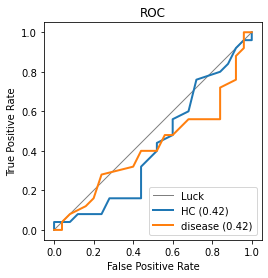

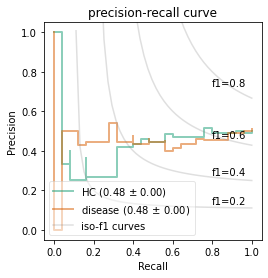

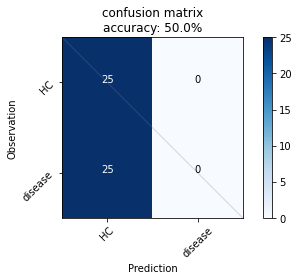

In [85]:
res=cu.classify_predict(exp2,'type',model,plot_it=True)

In [86]:
cu.classify_get_roc(res)

0.4224

In [92]:
cu.classify_get_accuracy(res)

failed to load logging config file


0.5

In [23]:
    num_exp = len(dat.sample_metadata['expid'].unique())


In [24]:
def classifier_performance_matrix(exp, use_subset_features=True, shuffle=False, shuffle_source=False):
    '''test the cross cohort classifier performance
    
    Parameters
    ----------
    exp: ca.Experiment with the different cohort subsets
    use_subset_features: bool, optional
        True to filter features for classifier before each cross-cohort classification (feature intersection of the 2 cohorts)
        False to use all the exp features for classifiers
    shuffle: bool, optional
        if True, randomize the HC/disease labels of validation cohort before predicting using the model (for null hypothesis values)
    shuffle_source: bool, optional
        if True, randomize the HC/disease labels of training cohort before predicting (for null hypothesis values)
    '''
    ca.set_log_level('ERROR')
    num_exp = len(exp.sample_metadata['expid'].unique())
    print('processing %d experiments' % num_exp)
    roc_mat = np.zeros([num_exp, num_exp])
    pred_mat30 = np.zeros([num_exp, num_exp])
    pred_mat25 = np.zeros([num_exp, num_exp])
    pred_mat35 = np.zeros([num_exp, num_exp])

    ids =[]
    for idx1, (id1,exp1) in enumerate(exp.iterate('expid')):
        if shuffle_source:
            exp1.sample_metadata['type'] = exp1.sample_metadata['type'].sample(frac=1).values
        exp1 = exp1.filter_sum_abundance(0,strict=True)
        ids.append(id1)
        # if not subset of features, train once on the exp1 dataset
        if not use_subset_features:
            model=cu.classify_fit(exp1,'type')
        for idx2, (id2, exp2) in enumerate(exp.iterate('expid')):
            exp2 = exp2.filter_sum_abundance(0,strict=True)
            cexp1 = exp1.filter_ids(exp2.feature_metadata.index)
            cexp2 = exp2.filter_ids(cexp1.feature_metadata.index)
            # if shuffle, mix the HC/disease of exp2
            if shuffle:
                cexp2.sample_metadata['type'] = cexp2.sample_metadata['type'].sample(frac=1).values

            # if same experiment, so do training/validation
            if idx1 == idx2:
                # keep 2/3 of samples
                cexp1 = cexp1.downsample('expid',keep=2*int(len(cexp1.sample_metadata)/3))
                cexp2 = cexp2.filter_ids(cexp1.sample_metadata.index,axis='s',negate=True)

            # if using subset features, train the model after subsetting
            if use_subset_features:
                model=cu.classify_fit(cexp1,'type')
        
            # now predict on exp2 and measure performance
            res=cu.classify_predict(cexp2, 'type', model,plot_it=False)
            roc_auc = cu.classify_get_roc(res)
            roc_mat[idx1,idx2] = roc_auc
#             y_pred = (res['HC'] >= 0.25).astype(bool)
#             pred_mat25[idx1,idx2] = accuracy_score(res['Y_TRUE']=='HC', y_pred)
#             y_pred = (res['HC'] >= 0.35).astype(bool)
#             pred_mat35[idx1,idx2] = accuracy_score(res['Y_TRUE']=='HC', y_pred)
#             y_pred = (res['HC'] >= 0.3).astype(bool)
#             pred_mat30[idx1,idx2] = accuracy_score(res['Y_TRUE']=='HC', y_pred)
    ca.set_log_level('INFO')
    return ids, roc_mat, pred_mat25, pred_mat30, pred_mat35

In [25]:
def plot_clustergram(roc_mat, ids):
    labels2=[(studies.loc[studies['mf']==x,'disease'].values + '(' + studies.loc[studies['mf']==x, 'authors'].values + ')')[0] for x in ids]
    labelsd2=[(studies.loc[studies['mf']==x,'disease'].values + '(' + studies.loc[studies['mf']==x, 'authors'].values + ')' + ' ' + str(x))[0] for x in ids]

    # set up the colors for disease
    diseases = {xx:studies.loc[studies['mf']==xx,'disease'].values[0] for xx in ids}
    disease_colors = {xx: (0,0,0) for xx in diseases.values()}
    disease_colors.update({'HIV': (1.00,0.93,0.35),'Autism': (0.50,0.99,0.52),'Bipolar': (1.00, 0.63, 0.00),
         'IBD_Crohn disease': (0.72,0.11,0.11),'IBD_Ulcerative Colitis': (0.72,0.11,0.11),
         'IBD_Inflammtory bowel disease': (0.72,0.11,0.11),
         'Diabetes T2': (0.47,0.53,0.80),
         'Depression': (0.48,0.12,0.64),
         'Obesity': (0.25,0.32,0.71),
         'Parkinson’s': (0.29,0.08,0.55),
         'Schizophrenia': (0.88,0.75,0.91),     
         'Gastroenteritis': (0.94,0.33,0.31),
         'Heart diseases': (0.33,0.43,1.00),
         'Irritable bowel syndrom': (0.90,0.45,0.45),
         'Alzheimer': (0.83, 0.83, 0.83), 'Anorexia': (0.83, 0.83, 0.83), 'Cancer': (0.83, 0.83, 0.83), 'Autoimmun diseases': (0.83, 0.83, 0.83), 'C.difficile infection': (0.83, 0.83, 0.83), 
         'Cancer': (0.83, 0.83, 0.83), 'Chronic fatigue syndrome': (0.83, 0.83, 0.83), 'Diabetes T1': (0.83, 0.83, 0.83),  'Gout': (0.83, 0.83, 0.83),
         'Hepatitis B': (0.83, 0.83, 0.83), 'Hepatitis C': (0.83, 0.83, 0.83), 'Hypertension': (0.83, 0.83, 0.83), 
         'Lupus': (0.83, 0.83, 0.83), 'Pancreatitis': (0.83, 0.83, 0.83), 'Psoriasis': (0.83, 0.83, 0.83), 'Rheumatoid arthritis': (0.83, 0.83, 0.83), 
                
         })
    sbs.set(font_scale=0.6)
    f=sbs.clustermap(roc_mat,xticklabels=labels2,yticklabels=labels2,cmap='bwr_r',metric='braycurtis',vmin=0,vmax=1,
                    row_colors=[disease_colors[diseases[x]] for x in ids],
                    col_colors=[disease_colors[diseases[x]] for x in ids])
    row_order = np.array(f.dendrogram_row.reordered_ind)
    col_order = np.array(f.dendrogram_col.reordered_ind)
    for idx,crow in enumerate(row_order):
        ccol = np.where(col_order==crow)[0]
        f.ax_heatmap.plot([ccol,ccol,ccol+0.9,ccol+0.9,ccol],[idx,idx+0.9,idx+0.9,idx,idx],'k',linewidth=1)
    return f

# True data

In [26]:
ids,roc_mat, pm25,pm30,pm35 = classifier_performance_matrix(dat,shuffle=False)

processing 59 experiments


KeyError: 'expid'

In [26]:
resdf = pd.DataFrame(roc_mat, index=ids, columns=ids)
resdf.to_csv('../classifier/classify-all.csv')

NameError: name 'roc_mat' is not defined

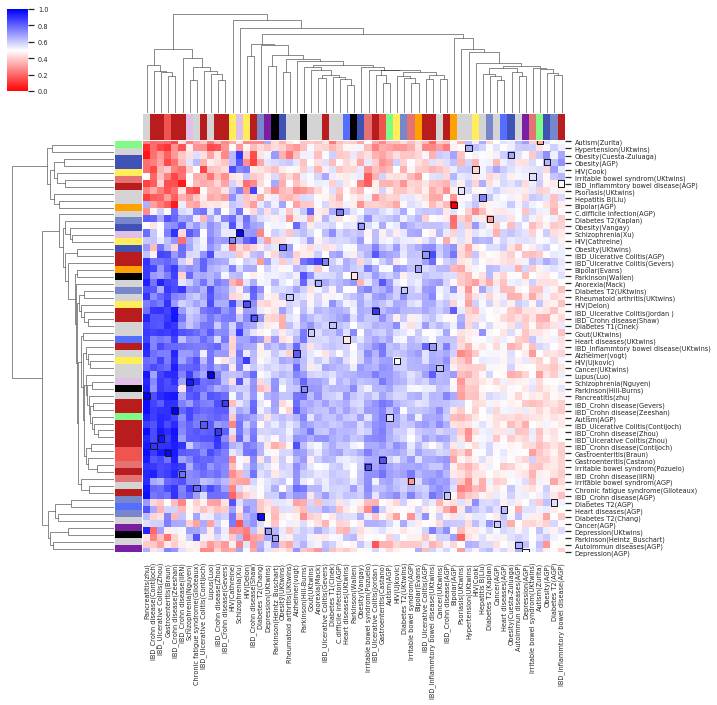

In [27]:
resdf=pd.read_csv('../classifier/classify-all.csv',index_col=0)
f=plot_clustergram(resdf,resdf.columns)
f.savefig('../figures/fig5/classifier-auc-all.pdf')

# Random dest

In [17]:
ids,roc_mat, pm25,pm30,pm35 = classifier_performance_matrix(dat,shuffle=True)

processing 59 experiments


KeyError: 'expid'

In [18]:
resdf = pd.DataFrame(roc_mat, index=ids, columns=ids)
resdf.to_csv('../classifier/classify-random-all.csv')

NameError: name 'roc_mat' is not defined

In [19]:
resdf=pd.read_csv('../classifier/classify-random-all.csv',index_col=0)
f=plot_clustergram(resdf,resdf.columns)
f.savefig('../figures/fig5/classifier-auc-random-all.pdf')

NameError: name 'plot_clustergram' is not defined

# Random source

In [29]:
ids,roc_mat, pm25,pm30,pm35 = classifier_performance_matrix(dat,shuffle_source=True)

processing 59 experiments


KeyError: 'expid'

In [ ]:
resdf = pd.DataFrame(roc_mat, index=ids, columns=ids)
resdf.to_csv('../classifier/classify-randsource-all.csv')

In [ ]:
resdf=pd.read_csv('../classifier/classify-randsource-all.csv',index_col=0)
f=plot_clustergram(resdf,resdf.columns)
f.savefig('../figures/fig5/classifier-auc-randsource-all.pdf')

# True data subset 40

In [30]:
ids,roc_mat, pm25,pm30,pm35 = classifier_performance_matrix(dat40,shuffle=False)

processing 48 experiments


In [31]:
resdf = pd.DataFrame(roc_mat, index=ids, columns=ids)
resdf.to_csv('../classifier/classify-40.csv')

/Users/amnon/miniconda3/envs/calour/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 61850 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/amnon/miniconda3/envs/calour/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 61850 missing from current font.
  font.set_text(s, 0, flags=flags)
/Users/amnon/miniconda3/envs/calour/lib/python3.7/site-packages/matplotlib/backends/_backend_pdf_ps.py:62: RuntimeWarning: Glyph 61850 missing from current font.
  font.set_text(s, 0.0, flags=ft2font.LOAD_NO_HINTING)
/Users/amnon/miniconda3/envs/calour/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 61850 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/amnon/miniconda3/envs/calour/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 61850 missing from current font.
  font.set_text(s, 0, flags=flags)


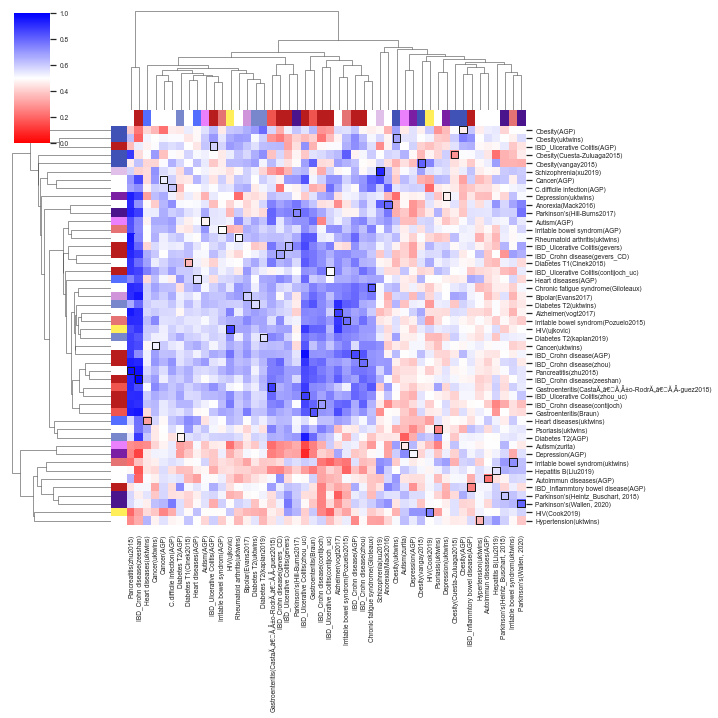

In [32]:
resdf=pd.read_csv('../classifier/classify-40.csv',index_col=0)
f=plot_clustergram(resdf,resdf.columns)
f.savefig('../figures/fig5/classifier-auc-40.pdf')

# True data subset 40 redo

In [33]:
ids,roc_mat, pm25,pm30,pm35 = classifier_performance_matrix(dat40,shuffle=False)

processing 48 experiments


In [34]:
resdf = pd.DataFrame(roc_mat, index=ids, columns=ids)
resdf.to_csv('../classifier/classify-40-redo.csv')

/Users/amnon/miniconda3/envs/calour/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 61850 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/amnon/miniconda3/envs/calour/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 61850 missing from current font.
  font.set_text(s, 0, flags=flags)
/Users/amnon/miniconda3/envs/calour/lib/python3.7/site-packages/matplotlib/backends/_backend_pdf_ps.py:62: RuntimeWarning: Glyph 61850 missing from current font.
  font.set_text(s, 0.0, flags=ft2font.LOAD_NO_HINTING)
/Users/amnon/miniconda3/envs/calour/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 61850 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/amnon/miniconda3/envs/calour/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 61850 missing from current font.
  font.set_text(s, 0, flags=flags)


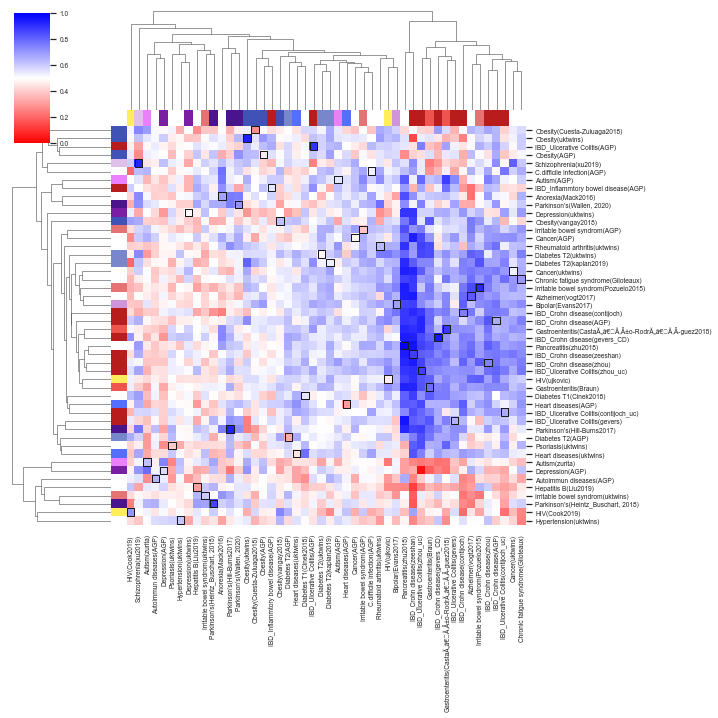

In [35]:
resdf=pd.read_csv('../classifier/classify-40-redo.csv',index_col=0)
f=plot_clustergram(resdf,resdf.columns)
f.savefig('../figures/fig5/classifier-auc-40-redo.pdf')

# Random dest subset 40

In [36]:
ids,roc_mat, pm25,pm30,pm35 = classifier_performance_matrix(dat40,shuffle=True)

processing 48 experiments


In [37]:
resdf = pd.DataFrame(roc_mat, index=ids, columns=ids)
resdf.to_csv('../classifier/classify-random-40.csv')

/Users/amnon/miniconda3/envs/calour/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 61850 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/amnon/miniconda3/envs/calour/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 61850 missing from current font.
  font.set_text(s, 0, flags=flags)
/Users/amnon/miniconda3/envs/calour/lib/python3.7/site-packages/matplotlib/backends/_backend_pdf_ps.py:62: RuntimeWarning: Glyph 61850 missing from current font.
  font.set_text(s, 0.0, flags=ft2font.LOAD_NO_HINTING)
/Users/amnon/miniconda3/envs/calour/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 61850 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/amnon/miniconda3/envs/calour/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 61850 missing from current font.
  font.set_text(s, 0, flags=flags)


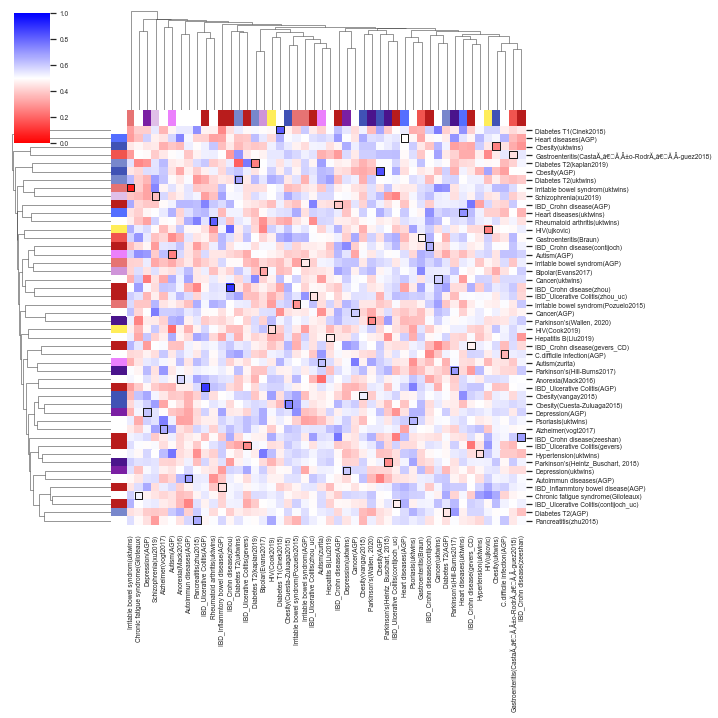

In [38]:
resdf=pd.read_csv('../classifier/classify-random-40.csv',index_col=0)
f=plot_clustergram(resdf,resdf.columns)
f.savefig('../figures/fig5/classifier-auc-random-40.pdf')

# Random source subset 40

In [39]:
ids,roc_mat, pm25,pm30,pm35 = classifier_performance_matrix(dat40,shuffle_source=True)

processing 48 experiments


In [40]:
resdf = pd.DataFrame(roc_mat, index=ids, columns=ids)
resdf.to_csv('../classifier/classify-randsource-40.csv')

/Users/amnon/miniconda3/envs/calour/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 61850 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/amnon/miniconda3/envs/calour/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 61850 missing from current font.
  font.set_text(s, 0, flags=flags)
/Users/amnon/miniconda3/envs/calour/lib/python3.7/site-packages/matplotlib/backends/_backend_pdf_ps.py:62: RuntimeWarning: Glyph 61850 missing from current font.
  font.set_text(s, 0.0, flags=ft2font.LOAD_NO_HINTING)
/Users/amnon/miniconda3/envs/calour/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 61850 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/amnon/miniconda3/envs/calour/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 61850 missing from current font.
  font.set_text(s, 0, flags=flags)


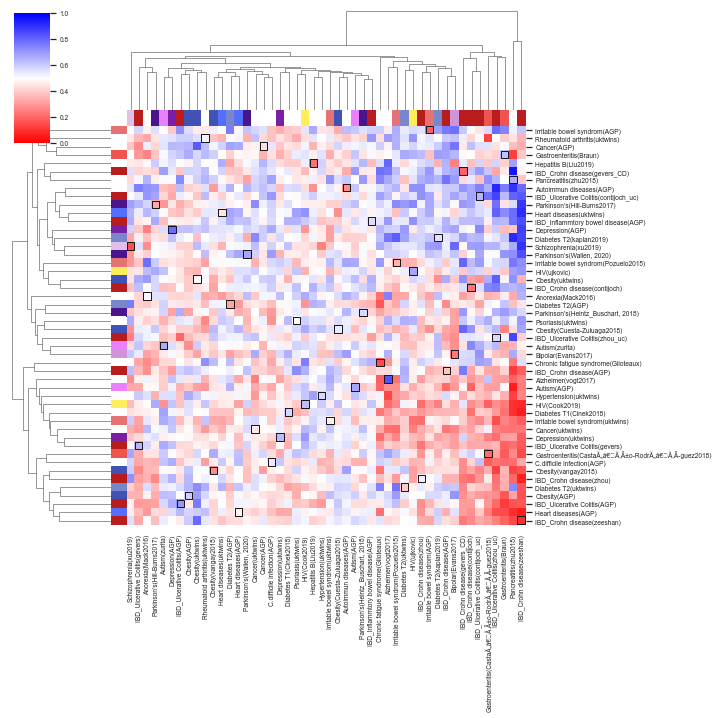

In [41]:
resdf=pd.read_csv('../classifier/classify-randsource-40.csv',index_col=0)
f=plot_clustergram(resdf,resdf.columns)
f.savefig('../figures/fig5/classifier-auc-randsource-40.pdf')

# Redo random source subset 40

In [42]:
ids,roc_mat, pm25,pm30,pm35 = classifier_performance_matrix(dat40,shuffle_source=True)

processing 48 experiments


In [43]:
resdf = pd.DataFrame(roc_mat, index=ids, columns=ids)
resdf.to_csv('../classifier/classify-randsource-40-redo.csv')

/Users/amnon/miniconda3/envs/calour/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 61850 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/amnon/miniconda3/envs/calour/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 61850 missing from current font.
  font.set_text(s, 0, flags=flags)
/Users/amnon/miniconda3/envs/calour/lib/python3.7/site-packages/matplotlib/backends/_backend_pdf_ps.py:62: RuntimeWarning: Glyph 61850 missing from current font.
  font.set_text(s, 0.0, flags=ft2font.LOAD_NO_HINTING)
/Users/amnon/miniconda3/envs/calour/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 61850 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/amnon/miniconda3/envs/calour/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 61850 missing from current font.
  font.set_text(s, 0, flags=flags)


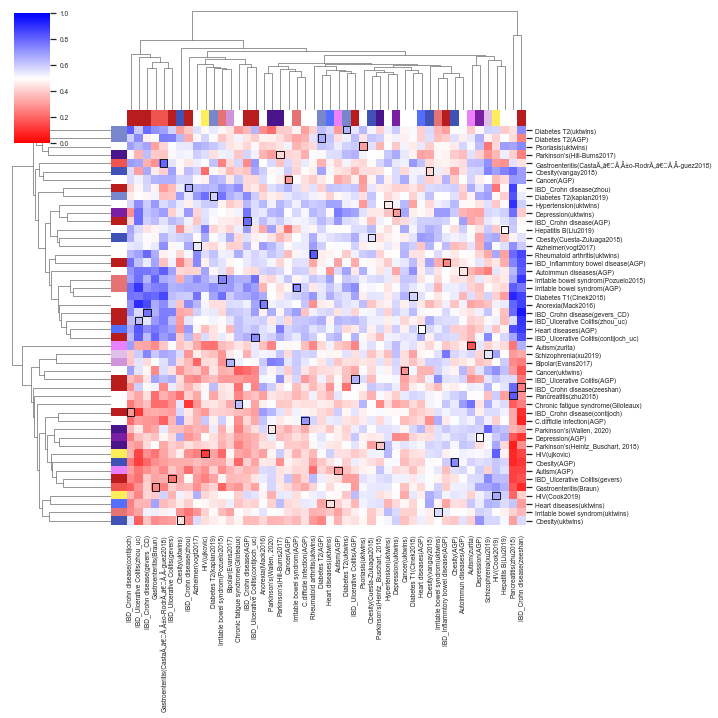

In [44]:
resdf=pd.read_csv('../classifier/classify-randsource-40-redo.csv',index_col=0)
f=plot_clustergram(resdf,resdf.columns)
f.savefig('../figures/fig5/classifier-auc-randsource-40-redo.pdf')

# random source and dest, subset40

In [45]:
ids,roc_mat, pm25,pm30,pm35 = classifier_performance_matrix(dat40,shuffle_source=True, shuffle=True)

processing 48 experiments


In [46]:
resdf = pd.DataFrame(roc_mat, index=ids, columns=ids)
resdf.to_csv('../classifier/classify-randsource-rand-40.csv')

/Users/amnon/miniconda3/envs/calour/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 61850 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/amnon/miniconda3/envs/calour/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 61850 missing from current font.
  font.set_text(s, 0, flags=flags)
/Users/amnon/miniconda3/envs/calour/lib/python3.7/site-packages/matplotlib/backends/_backend_pdf_ps.py:62: RuntimeWarning: Glyph 61850 missing from current font.
  font.set_text(s, 0.0, flags=ft2font.LOAD_NO_HINTING)
/Users/amnon/miniconda3/envs/calour/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 61850 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/amnon/miniconda3/envs/calour/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 61850 missing from current font.
  font.set_text(s, 0, flags=flags)


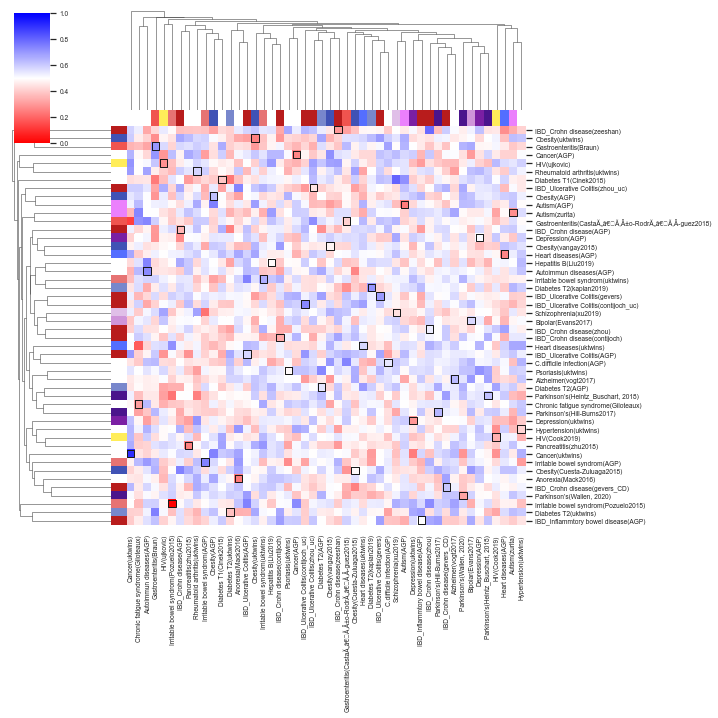

In [47]:
resdf=pd.read_csv('../classifier/classify-randsource-rand-40.csv',index_col=0)
f=plot_clustergram(resdf,resdf.columns)
f.savefig('../figures/fig5/classifier-auc-randsource-rand-40.pdf')

# Train on multipreordered_indrts../classifier/

In [48]:
qq=dat.filter_samples('disease',['crohn','ulcerative colitis','lupus','pancreatitis'])
# qq=qq.filter_sum_abundance(0,strict=True)

In [49]:
# remove 2 CD and lupus/pancreatitis from training
qqt=qq.filter_samples('expid',['21','27','14','13'],negate=True)
# and create validation set
qqv=qq.filter_ids(qqt.sample_metadata.index,axis='s',negate=True)

In [50]:
model=cu.classify_fit(qqt,'type')

ValueError: Found array with 0 sample(s) (shape=(0, 44537)) while a minimum of 1 is required.

In [ ]:
res=cu.classify_predict(qqv,'type',model)

In [ ]:
qqv=dat.filter_samples('expid','14')
res=cu.classify_predict(qqv,'type',model)

In [ ]:
qqv=dat.filter_samples('expid','13')
res=cu.classify_predict(qqv,'type',model)

In [ ]:
qqv=dat.filter_samples('expid','21')
res=cu.classify_predict(qqv,'type',model)

In [ ]:
qq=dat.filter_samples('disease',['crohn', 'ulcerative colitis'])
model=cu.classify_fit(qq,'type')
ids=[]
lauc=[]
disease=[]
for cid,cexp in dat.iterate('expid'):
    res=cu.classify_predict(cexp,'type',model,plot_it=False)
    acs=0
#     acs = accuracy_score(res['Y_TRUE']=='HC', res['HC'])
    auc = cu.classify_get_roc(res)
    cdisease = cexp.sample_metadata['disease'].unique()
    print('expid: %s (%s), roc:%f, accuracy:%f' % (cid, cdisease, auc, acs))
    ids.append(cid)
    lauc.append(auc)
    disease.append(cdisease[0])

lauc=np.array(lauc)
ids=np.array(ids)
disease=np.array(disease)
si=np.argsort(lauc)
lauc=lauc[si]
ids=ids[si]
disease=disease[si]
f=plt.figure()
plt.bar(np.arange(len(ids)),lauc,tick_label=disease)
plt.xticks(rotation=90,size=7)
plt.tight_layout()
f.savefig('../figures/classifier-allcduc.pdf')

In [ ]:
qq=dat.filter_samples('disease',['ulcerative colitis'])
model=cu.classify_fit(qq,'type')
ids=[]
lauc=[]
disease=[]
for cid,cexp in dat.iterate('expid'):
    res=cu.classify_predict(cexp,'type',model,plot_it=False)
    acs=0
#     acs = accuracy_score(res['Y_TRUE']=='HC', res['HC'])
    auc = cu.classify_get_roc(res)
    cdisease = cexp.sample_metadata['disease'].unique()
    print('expid: %s (%s), roc:%f, accuracy:%f' % (cid, cdisease, auc, acs))
    ids.append(cid)
    lauc.append(auc)
    disease.append(cdisease[0])

lauc=np.array(lauc)
ids=np.array(ids)
disease=np.array(disease)
si=np.argsort(lauc)
lauc=lauc[si]
ids=ids[si]
disease=disease[si]
f=plt.figure()
plt.bar(np.arange(len(ids)),lauc,tick_label=disease)
plt.xticks(rotation=90,size=7)
plt.tight_layout()
f.savefig('../figures/classifier-alluc.pdf')

In [ ]:
qq=dat.filter_samples('disease',['obesity'])
model=cu.classify_fit(qq,'type')
ids=[]
lauc=[]
disease=[]
for cid,cexp in dat.iterate('expid'):
    res=cu.classify_predict(cexp,'type',model,plot_it=False)
    acs=0
#     acs = accuracy_score(res['Y_TRUE']=='HC', res['HC'])
    auc = cu.classify_get_roc(res)
    cdisease = cexp.sample_metadata['disease'].unique()
    print('expid: %s (%s), roc:%f, accuracy:%f' % (cid, cdisease, auc, acs))
    ids.append(cid)
    lauc.append(auc)
    disease.append(cdisease[0])

lauc=np.array(lauc)
ids=np.array(ids)
disease=np.array(disease)
si=np.argsort(lauc)
lauc=lauc[si]
ids=ids[si]
disease=disease[si]
f=plt.figure()
plt.bar(np.arange(len(ids)),lauc,tick_label=disease)
plt.xticks(rotation=90,size=7)
plt.tight_layout()
f.savefig('../figures/classifier-allobese.pdf')

In [ ]:
qq=dat.filter_samples('disease',['obesity'])
model=cu.classify_fit(qq,'type')
ids=[]
lauc=[]
disease=[]
for cid,cexp in dat.iterate('expid'):
    cexp.sample_metadata['type'] = cexp.sample_metadata['type'].sample(frac=1).values
    res=cu.classify_predict(cexp,'type',model,plot_it=False)
    acs=0
#     acs = accuracy_score(res['Y_TRUE']=='HC', res['HC'])
    auc = cu.classify_get_roc(res)
    cdisease = cexp.sample_metadata['disease'].unique()
    print('expid: %s (%s), roc:%f, accuracy:%f' % (cid, cdisease, auc, acs))
    ids.append(cid)
    lauc.append(auc)
    disease.append(cdisease[0])

lauc=np.array(lauc)
ids=np.array(ids)
disease=np.array(disease)
si=np.argsort(lauc)
lauc=lauc[si]
ids=ids[si]
disease=disease[si]
f=plt.figure()
plt.bar(np.arange(len(ids)),lauc,tick_label=disease)
plt.xticks(rotation=90,size=7)
plt.ylim([0,1])
plt.tight_layout()
f.savefig('../figures/classifier-allobese-random.pdf')

In [ ]:
fdat=dat.filter_prevalence(0.1)
fdat=fdat.filter_mean_abundance(0.001)
# fdat=dat.filter_prevalence(0)
qq=fdat.filter_samples('disease',['ulcerative colitis'])
model=cu.classify_fit(qq,'type')
ids=[]
lauc=[]
disease=[]
for cid,cexp in fdat.iterate('expid'):
    res=cu.classify_predict(cexp,'type',model,plot_it=False)
    acs=0
#     acs = accuracy_score(res['Y_TRUE']=='HC', res['HC'])
    auc = cu.classify_get_roc(res)
    cdisease = cexp.sample_metadata['disease'].unique()
    print('expid: %s (%s), roc:%f, accuracy:%f' % (cid, cdisease, auc, acs))
    ids.append(cid)
    lauc.append(auc)
    disease.append(cdisease[0])

lauc=np.array(lauc)
ids=np.array(ids)
disease=np.array(disease)
si=np.argsort(lauc)
lauc=lauc[si]
ids=ids[si]
disease=disease[si]
f=plt.figure()
plt.bar(np.arange(len(ids)),lauc,tick_label=disease)
plt.xticks(rotation=90,size=7)
plt.tight_layout()
# f.savefig('../figures/classifier-alluc.pdf')

In [ ]:
dat.sample_metadata.expid.value_counts()

In [ ]:
studies

In [ ]:
dat40.sample_metadata.expid.value_counts()

In [ ]:
tt=ca.read_amplicon('../allsamples/allsamples-min40-no-bloom.biom','../allsamples/allsamples-min40-no-bloom_sample.txt',min_reads=1000,normalize=10000)

In [ ]:
tt.sample_metadata['expid']=tt.sample_metadata.apply(lambda x: str(x['exp'].split('/')[-1]), axis=1)


In [ ]:
dat40.sample_metadata.expid.value_counts()

In [ ]:
resdf

In [ ]:
len(dat40.sample_metadata.expid.unique())